In [1]:
from Data import AnnaDataset, InvertAnna
from Models.CharRNN import CharRNN
from Utils.HelperFunctions import *
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tnrange
import matplotlib.pyplot as plt
import numpy as np
import gc
import os
%matplotlib inline  
# use gpu when possible
mydevice = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# parameters
BATCH_SIZE = 1024
N_STEPS = 10
N_HIDDEN = 512
N_LAYERS = 2
N_EPOCHS = 101
learning_rates = np.asarray([1e-3,1e-4,1e-5,1e-6,1e-7,1e-8])
N_REPS = len(learning_rates)

dataset = AnnaDataset(N_STEPS)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE,
                        shuffle=True, num_workers=4)

N_INPUTS = len(dataset.categories)
N_OUTPUTS = N_INPUTS

In [3]:
train_loss = np.zeros((N_EPOCHS,N_REPS))
train_acc = np.zeros((N_EPOCHS,N_REPS))

model = [None]*N_REPS
for rep in tnrange(N_REPS):
    model[rep] = CharRNN(N_INPUTS,N_HIDDEN,N_OUTPUTS,N_LAYERS,"gru",mydevice).to(mydevice)
    optimizer = torch.optim.RMSprop(model[rep].parameters(), lr=learning_rates[rep], momentum=0.9)
    criterion = nn.CrossEntropyLoss()
    model[rep].train()
    for epoch in tnrange(N_EPOCHS):
        running_train_loss = 0
        running_train_acc = 0
        for i, (x,y_tar) in enumerate(dataloader):
            x, y_tar = x.to(mydevice), y_tar.to(mydevice)
            y_pred, hidden = model[rep](x)
            loss = criterion(y_pred.permute(1,2,0),y_tar)
            loss.backward()
            optimizer.step()
            running_train_loss+=loss.item()
            running_train_acc+=get_accuracy(y_pred.permute(1,2,0), y_tar)
        train_loss[epoch,rep] = running_train_loss/(i+1)
        train_acc[epoch,rep] = running_train_acc/(i+1)

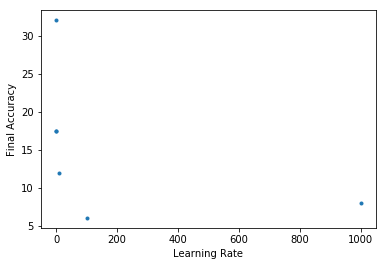

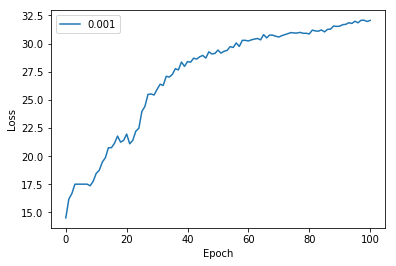

In [4]:
plt.plot(learning_rates*1e6,train_acc[-1,:],'.')
plt.ylabel('Final Accuracy')
plt.xlabel('Learning Rate')
plt.show()
plt.plot(train_acc[:,np.argmax(train_acc[-1,:])])
plt.legend(learning_rates)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [31]:
train_loss_LSTM = np.zeros((N_EPOCHS,N_REPS))
train_acc_LSTM = np.zeros((N_EPOCHS,N_REPS))

model_LSTM = [None]*N_REPS
for rep in tnrange(N_REPS):
    model_LSTM[rep] = CharRNN(N_INPUTS,N_HIDDEN,N_OUTPUTS,N_LAYERS,'lstm',mydevice).to(mydevice)
    optimizer = torch.optim.RMSprop(model_LSTM[rep].parameters(), lr=learning_rates[rep], momentum=0.9)
    criterion = nn.CrossEntropyLoss()
    model_LSTM[rep].train()
    for epoch in tnrange(N_EPOCHS):
        running_train_loss = 0
        running_train_acc = 0
        for i, (x,y_tar) in enumerate(dataloader):
            x, y_tar = x.to(mydevice), y_tar.to(mydevice)
            y_pred, hidden = model_LSTM[rep](x)
            loss = criterion(y_pred.permute(1,2,0),y_tar)
            loss.backward()
            optimizer.step()
            running_train_loss+=loss.item()
            running_train_acc+=get_accuracy(y_pred.permute(1,2,0), y_tar)
        train_loss_LSTM[epoch,rep] = running_train_loss/(i+1)
        train_acc_LSTM[epoch,rep] = running_train_acc/(i+1)

RuntimeError: Expected hidden[0] size (2, 128, 512), got (128, 512)

In [5]:
plt.plot(np.log10(learning_rates),train_acc_LSTM[-1,:],'.')
plt.ylabel('Final Accuracy')
plt.xlabel('Learning Rate')
plt.show()

NameError: name 'train_acc_LSTM' is not defined

In [6]:
model[0].eval()
x, y_tar = next(iter(dataloader))
y_pred, hidden = model[0](x.to(mydevice))
print(''.join(InvertTolstoy(torch.max(y_pred.permute(1,2,0), 1)[1].data[1,].to(mydevice))))
print(''.join(InvertTolstoy(y_tar[1,].to(mydevice))))

#model_LSTM[1].eval()
#x, y_tar = next(iter(dataloader))
#y_pred_LSTM, hidden_LSTM = model_LSTM[1](x.to(mydevice))
#(torch.max(y_pred_LSTM.permute(1,2,0), 1)[1].data[1,]==y_tar[1,].to(mydevice)).type(torch.DoubleTensor).mean()

NameError: name 'InvertTolstoy' is not defined

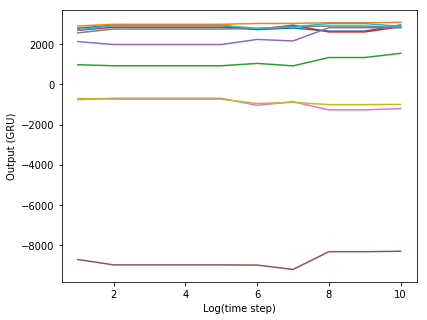

In [8]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(np.arange(1,N_STEPS+1),y_pred.permute(1,2,0).data.cpu().numpy()[0,:10,:].T,'-')
plt.ylabel('Output (GRU)')
plt.xlabel('Log(time step)')
#plt.subplot(1,2,2)
#plt.plot(np.arange(1,101),y_pred_LSTM.permute(1,2,0).data.cpu().numpy()[0,:,:].T,'-')
#plt.ylabel('Output (LSTM)')
#plt.xlabel('Log(time step)')
plt.show()

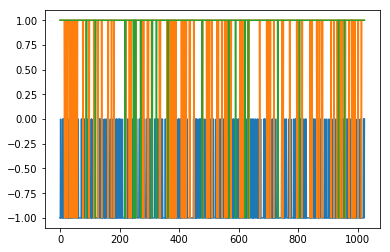

In [9]:

plt.plot(hidden.data[0,:,:3].cpu().numpy().squeeze())
plt.show()

In [12]:
x.shape

torch.Size([128, 100, 88])